In [5]:
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
#import ee
import folium
import geehydro

This notebook describes the process of downloading landcover data for downstream use in pretraining our glacier models. The idea is that learning to classify water vs. forest vs. snow might give more task diversity for learning meaningful features in the HKH imagery. First, we can load in a polygon specifying the region from which to download data. This polygon was constructed manually by outlining the full `Glaciers_2005.shp` multipolygon in QGIS.

<Axes: >

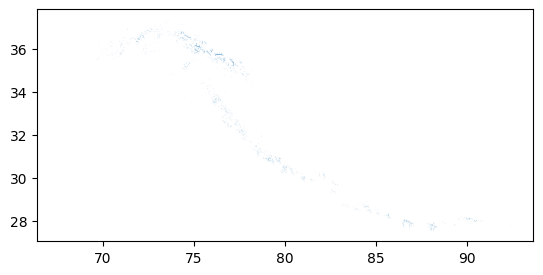

: 

In [12]:
data_dir = Path("../glacier_data")
glacier_bounds = gpd.read_file(data_dir / "vector_data/debris.shp")
glacier_bounds.plot()

Next, let's extract some data from the `COPERNICUS/Landcover` product. This gives landcover classification at a 100 meter resolution, which can be an auxiliary task for pretraining. The bands correspond to,

```
bands = ["discrete_classification", "discrete_classification-proba", "bare-coverfraction", "urban-coverfraction", "crops-coverfraction", "grass-coverfraction", "moss-coverfraction", "water-permanent-coverfraction", "water-seasonal-coverfraction", "shrub-coverfraction", "snow-coverfraction", "tree-coverfraction", "forest_type", "data-density-indicator"]
```


In [ ]:
ee.Initialize()
geom = ee.Geometry.Polygon(glacier_bounds.__geo_interface__["features"][0]["geometry"]["coordinates"])
aoi = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global").filterBounds(geom)
images = aoi.filterDate('2015-11-01', '2015-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 3)).median()

Finally, we can build up the task and export the data to google drive.

In [ ]:
task_config = {"region": geom, "crs": "epsg:4326", "scale": 30, "maxPixels": 4932644389}
image = ee.Image(aoi.first()).clip(geom)
task = ee.batch.Export.image(image, "landcover", task_config)
task.start()